# FEDERATED LEARNING

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import numpy as np

# Collect data

Dataset documentation : "https://cas.uqam.ca/pub/web/CASdatasets-manual.pdf"

Here, we concentrate on 3 different datasets on Motor Insurers : 
- `freMPL` (*French Motor Personal Line datasets*): This collection of ten datasets comes from a private motor French insurer. Each dataset includes risk features, claim amount and claim history of around 30,000 policies for year 2004. We decided to concacenate the differents freMPL datasets to focus on statistics.
- `beMTPL16` (*Belgian motor third-part liability dataset*): The dataset beMTPL was collected by an unknown Belgium insurer. It consists of 70 791 claims for private motor insurance.
- `euMTPL` (*European motor TPL insurance*): The euMTPL compiles three years of experience from a European MTPL (Motor Third Party Liability) portfolio, including frequency and severity values for different types of losses. The data was collected during the first decade of the 21st century.

In [7]:
# Change the paths to the location of the data on your machine
fre_path="/home/onyxia/work/Federated_Learning_Milliman/data_comparaison/freMPL.csv"
be_path="/home/onyxia/work/Federated_Learning_Milliman/data_comparaison/beMTPL97.rda"
eu_path="/home/onyxia/work/Federated_Learning_Milliman/data_comparaison/euMTPL.rda"
file_paths = [be_path, eu_path]

In [8]:
def load_rda(file_paths):
  dataframes = {}
  for file_path in file_paths:
      result = pyreadr.read_r(file_path)
      for key in result.keys():
          dataframes[key] = result[key]
  return dataframes

In [9]:
df_fre=pd.read_csv(fre_path)

In [10]:
df_0 = load_rda(file_paths)
dataframes = {
    "French": df_fre,
    "Belgium": df_0["beMTPL97"],
    "European": df_0["euMTPL"]
}

In [11]:
print("French columns:", dataframes["French"].columns)
print("Belgium columns:", dataframes["Belgium"].columns)
print("European columns:", dataframes["European"].columns)


French columns: Index(['Exposure', 'LicAge', 'RecordBeg', 'Gender', 'MariStat', 'SocioCateg',
       'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus', 'ClaimAmount',
       'ClaimInd'],
      dtype='object')
Belgium columns: Index(['id', 'expo', 'claim', 'nclaims', 'amount', 'average', 'coverage',
       'ageph', 'sex', 'bm', 'power', 'agec', 'fuel', 'use', 'fleet',
       'postcode', 'long', 'lat'],
      dtype='object')
European columns: Index(['policy_id', 'group', 'fuel_type', 'year', 'vehicle_category',
       'vehicle_use', 'province', 'horsepower', 'gender', 'age', 'exposure',
       'cost_nc', 'num_nc', 'cost_cg', 'num_cg', 'cost_fcg', 'num_fcg',
       'cost_cd', 'num_cd'],
      dtype='object')


In [12]:
print("French columns:", np.shape(dataframes["French"]))
print("be columns:", np.shape(dataframes["Belgium"]))
print("eu columns:", np.shape(dataframes["European"]))


French columns: (243065, 12)
be columns: (163212, 18)
eu columns: (2373197, 19)


In [13]:
dataframes["European"]["cost_claim"] = dataframes["European"]["cost_nc"] + dataframes["European"]["cost_cg"] + dataframes["European"]["cost_fcg"] + dataframes["European"]["cost_cd"] 


In [14]:
dataframes["European"]["cost_claim"].describe()

count    2.373197e+06
mean     3.058943e+02
std      4.005364e+03
min     -1.034309e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.452709e+06
Name: cost_claim, dtype: float64

# Choice of the variables to compare & Data Cleaning

Since the datasets are not identical, we need to select a common variable that will serve as the basis for comparison.
The target target variables are : 
- `Exposure` (*French :*`Exposure`, *Belgium :*`expo`, *European :*`exposure`): a numeric time of exposure, in years. -- **integer**
- `DriverAge` (*French :*`DrivAge`, *Belgium :*`ageph`, *European :*`age`): age of the driver -- **integer**
- `Gender` (*French :*`Gender`, *Belgium :*`sex`, *European :*`gender`): gender of the driver -- **{Male: 0,Female: 1}**
- `VehiculeUsage` (*French :*`VehUsage`, *Belgium :*`use`, *European :*`vehicle_use`): age of the driver -- **integer**
- `ClaimAmout` (*French :*`ClaimAmount`, *Belgium :*``, *European :*`cost_...`(differnt variables)):Total claim amount of the guarantee -- **real number**. For the european dataset, We will sum all the different `cost`variables to agregate all the sinisters.

Since the datasets have different variables, it is challenging to compare them accurately. Moreover, the French database had to be concatenated, and some variables had to be removed, for example.

In [15]:
french_data = dataframes["French"].rename(columns={
    'Exposure': 'Exposure',
    'DrivAge': 'DriverAge',
    'Gender': 'Gender',
    'VehUsage': 'VehiculeUsage',
    'ClaimAmount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

belgium_data = dataframes["Belgium"].rename(columns={
    'expo': 'Exposure',
    'ageph': 'DriverAge',
    'sex': 'Gender',
    'use': 'VehiculeUsage',
    'amount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

european_data = dataframes["European"].rename(columns={
    'exposure': 'Exposure',
    'age': 'DriverAge',
    'gender': 'Gender',
    'vehicle_use': 'VehiculeUsage',
    'cost_claim': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]


### Sample the European data to approximize the size of the French and Belgium data

In [16]:
reduction_factor = 10
sample_size = len(european_data) // reduction_factor
european_data = european_data.sample(sample_size)

french_size = len(french_data)
belgium_size = len(belgium_data)
european_size = len(european_data)

total_size = french_size + belgium_size + european_size

french_proportion = 100 * (french_size / total_size)
belgium_proportion = 100 * (belgium_size / total_size)
european_proportion = 100 * (european_size / total_size)

print("French Proportion :", round(french_proportion, 2), "%")
print("Belgium Proportion :", round(belgium_proportion, 2), "%")
print("European Proportion :", round(european_proportion, 2), "%")


French Proportion : 37.77 %
Belgium Proportion : 25.36 %
European Proportion : 36.87 %


In [17]:
french_data['Sinistre'] = (french_data['ClaimAmount'] > 0).astype(int)
belgium_data['Sinistre'] = (belgium_data['ClaimAmount'] > 0).astype(int)
european_data['Sinistre'] = (european_data['ClaimAmount'] > 0).astype(int)

french_data['Gender'] = french_data['Gender'].replace({'Female': 1, 'Male': 0})
belgium_data['Gender'] = belgium_data['Gender'].replace({'female': 1, 'male': 0})
european_data['Gender'] = european_data['Gender'].replace({'F': 1, 'M': 0})


french_data['Dataset'] = 'french'
belgium_data['Dataset'] = 'belgium'
european_data['Dataset'] = 'european'

df=pd.concat([french_data, belgium_data, european_data])
df


/tmp/ipykernel_112437/2084481182.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  french_data['Gender'] = french_data['Gender'].replace({'Female': 1, 'Male': 0})
/tmp/ipykernel_112437/2084481182.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  belgium_data['Gender'] = belgium_data['Gender'].replace({'female': 1, 'male': 0})
/tmp/ipykernel_112437/2084481182.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases t

,Exposure,DriverAge,Gender,VehiculeUsage,ClaimAmount,Sinistre,Dataset
0,0.583000,55,1,Professional,0.000000,0,french
1,0.200000,34,0,Private+trip to office,0.000000,0,french
2,0.083000,33,1,Professional,0.000000,0,french
3,0.375000,34,1,Professional,0.000000,0,french
4,0.500000,53,0,Professional,1418.610272,1,french
...,...,...,...,...,...,...,...
2183980,0.906849,39,0,1,0.000000,0,european
1582090,1.000000,54,0,1,0.000000,0,european
2317176,0.049315,31,1,1,0.000000,0,european
1718399,1.000000,58,0,1,0.000000,0,european


In [18]:
df['VehiculeUsage'].unique()

array(['Professional', 'Private+trip to office', 'Private',
       'Professional run', 'private', 'work', '1', '0', '5', '26', '4'],
      dtype=object)

In [19]:
### STATISTIQUES DESCS

In [20]:
# Statistiques générales
print("\n📊 Statistiques descriptives globales :")
print(df.describe())

# Statistiques descriptives par base (Dataset)
print("\n📊 Statistiques descriptives par dataset :")
print(df.groupby("Dataset").describe())

# Vérifier les valeurs manquantes
print("\n🔍 Nombre de valeurs manquantes par colonne :")
print(df.isnull().sum())



📊 Statistiques descriptives globales :


            Exposure      DriverAge         Gender    ClaimAmount  \
count  643596.000000  643596.000000  643596.000000  643596.000000   
mean        0.623976      47.559694       0.346590     206.127775   
std         0.348139      14.826783       0.475884    2659.219972   
min         0.001000      18.000000       0.000000   -5700.000000   
25%         0.293151      36.000000       0.000000       0.000000   
50%         0.666000      46.000000       0.000000       0.000000   
75%         1.000000      58.000000       1.000000       0.000000   
max         1.000000     107.000000       1.000000  802620.270997   

            Sinistre  
count  643596.000000  
mean        0.081873  
std         0.274171  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

📊 Statistiques descriptives par dataset :
          Exposure                                                         \
             count      mean       std      min    

/tmp/ipykernel_112437/2515778161.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y="Exposure", data=df, palette="pastel")


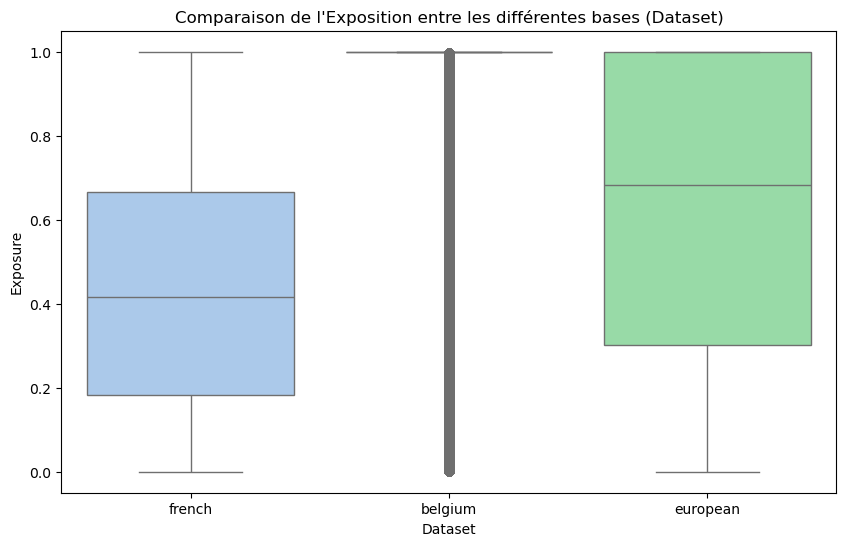

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Dataset", y="Exposure", data=df, palette="pastel")  
plt.title("Comparaison de l'Exposition entre les différentes bases (Dataset)")
plt.show()

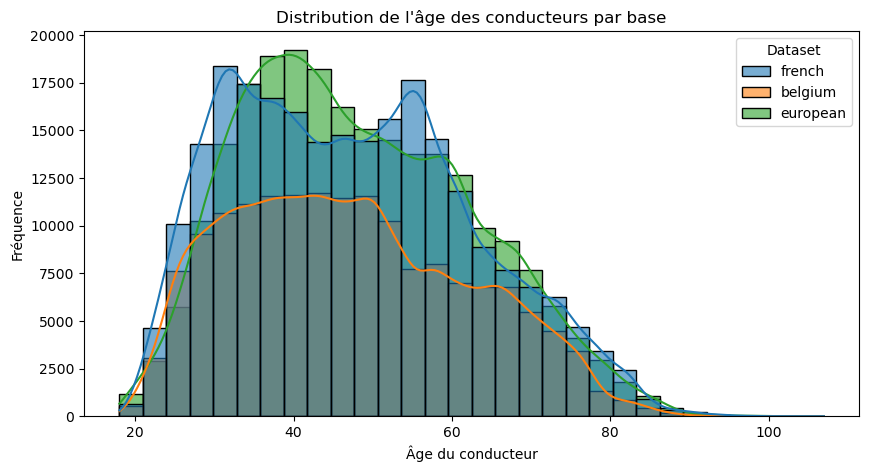

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="DriverAge", hue="Dataset", kde=True, bins=30, alpha=0.6)
plt.title("Distribution de l'âge des conducteurs par base")
plt.xlabel("Âge du conducteur")
plt.ylabel("Fréquence")
plt.show()


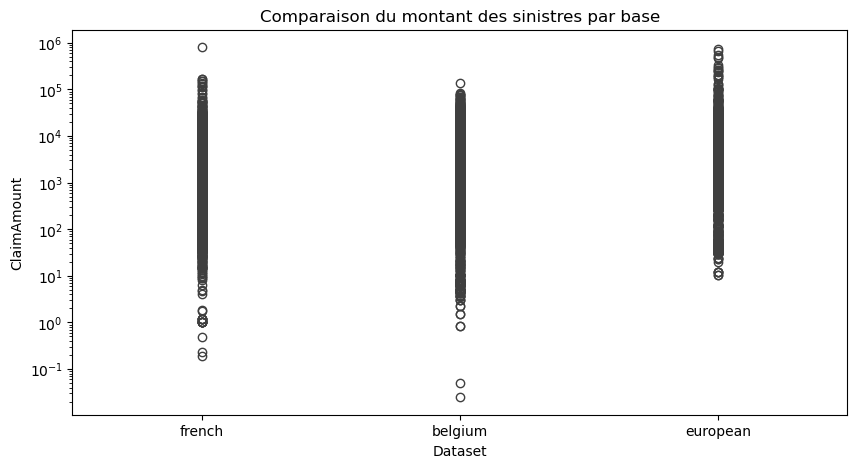

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="Dataset", y="ClaimAmount")
plt.yscale("log") 
plt.title("Comparaison du montant des sinistres par base")
plt.show()


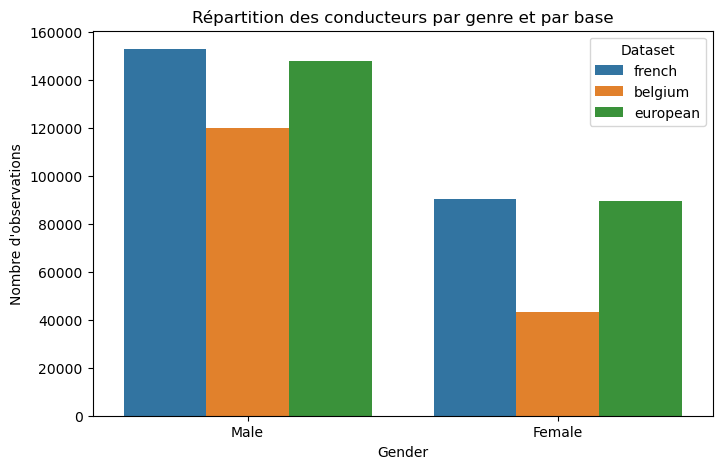

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Gender", hue="Dataset")
plt.xticks([0, 1], ["Male", "Female"])
plt.title("Répartition des conducteurs par genre et par base")
plt.ylabel("Nombre d'observations")
plt.show()


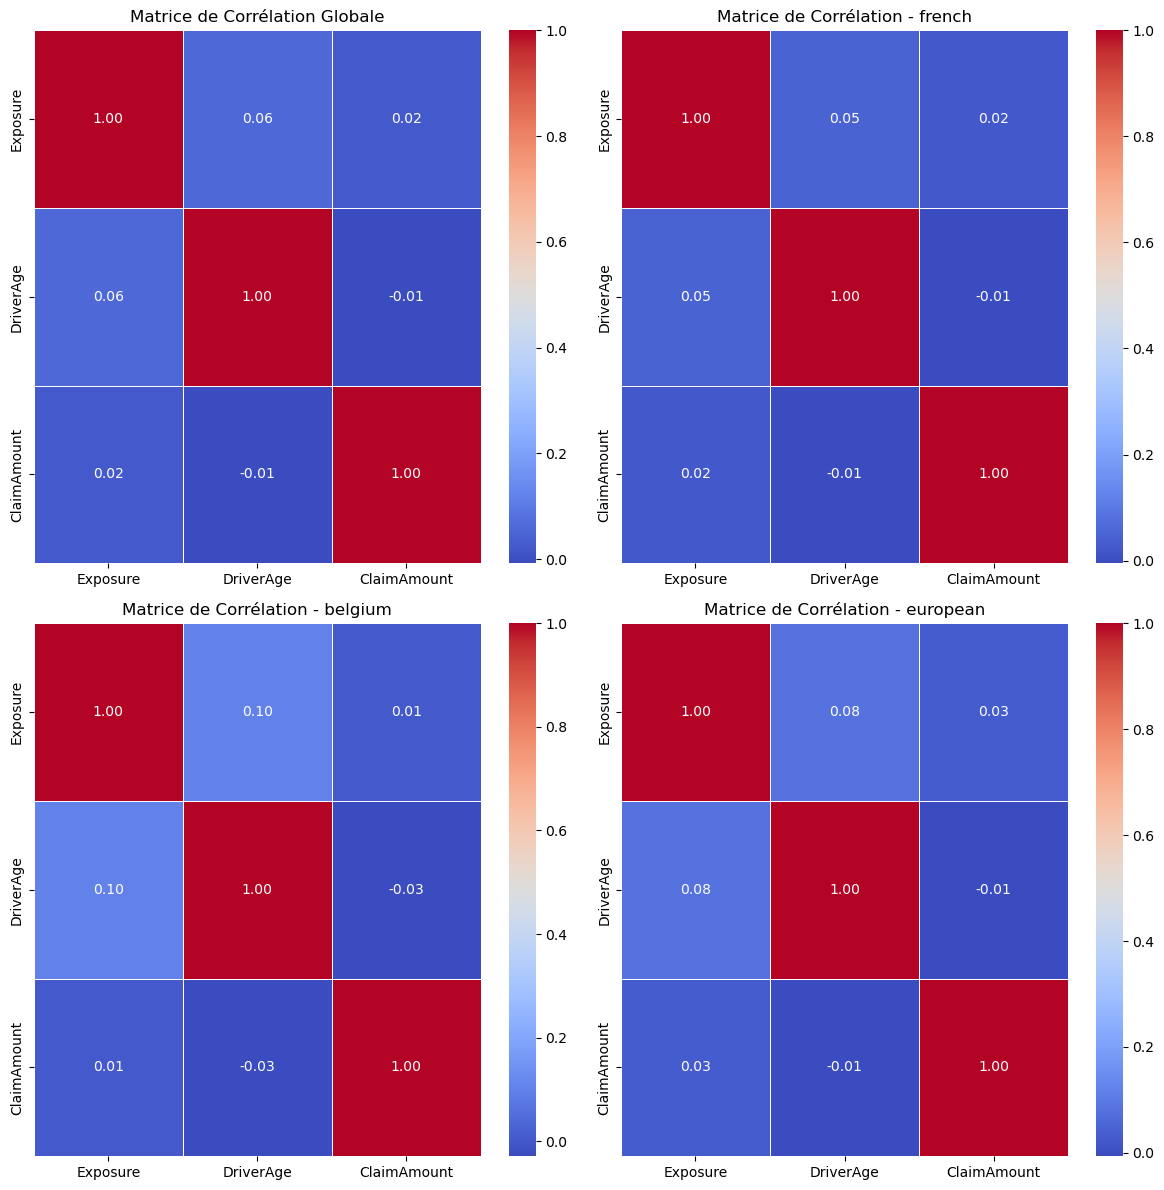

In [25]:
df_numeric = df.select_dtypes(include=['number']).drop(columns=['Gender', 'Sinistre']).copy()
df_numeric['Dataset'] = df['Dataset']
global_corr = df_numeric.drop(columns=['Dataset']).corr()
dataset_corr = df_numeric.groupby('Dataset').corr()
datasets = df['Dataset'].unique()
n_datasets = len(datasets)
cols = 2  
rows = int(np.ceil((n_datasets + 1) / cols))  

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))

ax = axes[0, 0] if n_datasets > 1 else axes
sns.heatmap(global_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax)
ax.set_title("Matrice de Corrélation Globale")

for i, dataset in enumerate(datasets):
    row, col = divmod(i + 1, cols)  
    ax = axes[row, col] if n_datasets > 1 else axes 
    if dataset in dataset_corr.index:
        sns.heatmap(dataset_corr.loc[dataset], annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax)
        ax.set_title(f"Matrice de Corrélation - {dataset}")
    else:
        ax.axis("off")  

for i in range(n_datasets + 1, rows * cols):
    axes.flat[i].axis("off")

plt.tight_layout() 
plt.show()


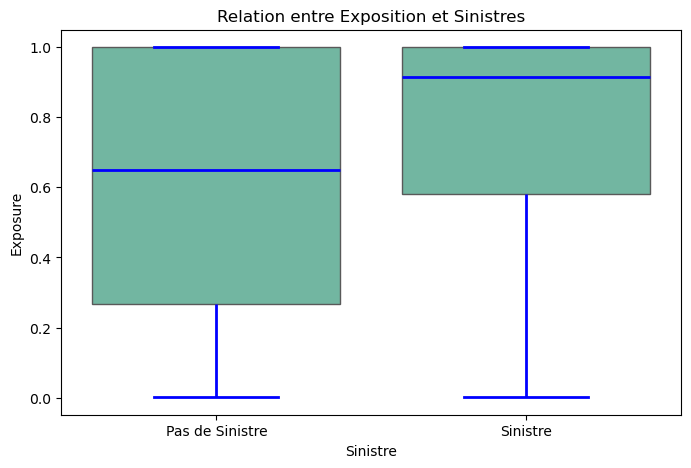

In [26]:
exposure_sinistre = df.groupby("Sinistre")["Exposure"].mean()
plt.figure(figsize=(8, 5))
sns.set_palette("Set2") 

ax = sns.boxplot(x="Sinistre", y="Exposure", data=df)
for patch in ax.artists: 
    patch.set_edgecolor('black')  
for line in ax.lines:
    if line.get_markerfacecolor() == line.get_markeredgecolor(): 
        line.set_color('blue')  
        line.set_linewidth(2) 

plt.xticks(ticks=[0, 1], labels=["Pas de Sinistre", "Sinistre"])
plt.title("Relation entre Exposition et Sinistres")
plt.show()


Regression logistique 